# StackOverflow Question Score Prediction

This notebook builds a series of regression baselines and progressively more expressive text models to predict StackOverflow question scores from their title and body text.

## Experiment Outline
- Load the StackOverflow dataset and prepare train/validation/test splits (70/15/15).
- Preprocess text (lower-case, whitespace normalization, tokenization, stopword removal) on the combined title+body field.
- Establish strong baselines: mean predictor and a question-length linear regression.
- Train Bag-of-Words and TF-IDF models with linear regression heads, including a stemmed variant.
- Explore TF-IDF bigrams, TF-IDF + Truncated SVD, and SVD features enriched with hand-engineered numeric signals.
- Compare models on the validation set, retrain the top contenders on train+validation, and report final test performance with diagnostic plots.

In [1]:
from __future__ import annotations

from pathlib import Path
from typing import Callable, Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from nltk import download as nltk_download
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import sys

PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / "data").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
NOTEBOOKS_DIR = PROJECT_ROOT / "notebooks"

for path in {PROJECT_ROOT, NOTEBOOKS_DIR}:
    path_str = str(path)
    if path_str not in sys.path:
        sys.path.append(path_str)

from notebooks.algorithms.text_utils import (
    extract_code_statistics,
    preprocess_text,
    tokens_to_text,
)

plt.style.use("seaborn-v0_8")
pd.set_option("display.max_colwidth", 140)
RANDOM_STATE = 42
DATA_PATH = PROJECT_ROOT / "data" / "stackexchange_dataset.csv"
print(f"Using data file: {DATA_PATH}")
from time import perf_counter


Using data file: C:\Users\tomasz.makowski.2\Desktop\SemesterII\AdvancedDataMining\adm-stack-inference\data\stackexchange_dataset.csv


## Load and Inspect the Dataset
The CSV file bundles StackOverflow questions with metadata. The columns of interest are the title, the long-form question text (`question_text`), and the numeric score (`question_score`).

In [2]:
raw_df = pd.read_csv(DATA_PATH)
print(f"Raw rows: {len(raw_df):,}")

df = (
    raw_df.rename(
        columns={
            "question_text": "body",
            "question_score": "score",
        }
    )[
        ["question_id", "title", "body", "score", "num_tags", "tags"]
    ]
    .dropna(subset=["title", "body", "score"])
    .copy()
)
df["score"] = pd.to_numeric(df["score"], errors="coerce")
df = df.drop_duplicates()
df = df.dropna(subset=["score"])
df["score"] = df["score"].astype(float)
df["title"] = df["title"].fillna("").astype(str)
df["body"] = df["body"].fillna("").astype(str)
df["full_text"] = (df["title"].str.strip() + " " + df["body"].str.strip()).str.strip()
df = df[df["full_text"].str.len() > 0]
df["num_tags"] = df["num_tags"].fillna(0).astype(int)
print(f"Filtered rows: {len(df):,}")
df.head()

Raw rows: 100,000
Filtered rows: 99,992


,question_id,title,body,score,num_tags,tags,full_text
0,79802517,Looking for a better way using &quot;.Include&quot; in EF,"I am looking for a better way to use the .Include clause of Entity Framework. I want to avoid duplicate code. I have a lot of classes, a...",2.0,2,"['c#', 'entity-framework']",Looking for a better way using &quot;.Include&quot; in EF I am looking for a better way to use the .Include clause of Entity Framework. ...
1,79802934,"NTP is moving my clock further from the correct time, rather than closer","Windows 11 Pro 10.0.26200 Build 26200. Dell XPS 8940. When I first started noticing it, a few weeks ago, my clock was about 12 seconds b...",0.0,1,['ntp'],"NTP is moving my clock further from the correct time, rather than closer Windows 11 Pro 10.0.26200 Build 26200. Dell XPS 8940. When I fi..."
2,79802909,Execution of pandas&#39; info in python,"I am new to pandas library in python. When I loaded a file and was printing the output of df.info into console, the data is getting prin...",0.0,2,"['python', 'pandas']",Execution of pandas&#39; info in python I am new to pandas library in python. When I loaded a file and was printing the output of df.inf...
3,79802932,How to debug MongoDB recurring error 314 ObjectIsBusy,"On a fresh Mongo DB 8.0 mono instance (no cluster) community edition install on Debian and through the package manager, i have a recurri...",0.0,4,"['database', 'mongodb', 'nosql', 'system-administration']",How to debug MongoDB recurring error 314 ObjectIsBusy On a fresh Mongo DB 8.0 mono instance (no cluster) community edition install on De...
4,79802919,How to integrate QML UI into a custom Vulkan renderer without using a separate window,I'm developing a custom Vulkan renderer and want to integrate a QML-based UI into it. I already have a working Vulkan setup and also man...,0.0,4,"['c++', 'qt', 'qml', 'vulkan']",How to integrate QML UI into a custom Vulkan renderer without using a separate window I'm developing a custom Vulkan renderer and want t...


## Text Preprocessing and Feature Extraction
The preprocessing pipeline follows the requested steps: lower-casing, whitespace collapsing, tokenization, stopword removal (with technical-token whitelisting), and optional stemming. Extra numeric features capture useful heuristics.

In [3]:
nltk_download('stopwords', quiet=True)
stopword_list = stopwords.words('english')
stemmer = PorterStemmer()

norm_texts: List[str] = []
clean_texts: List[str] = []
clean_texts_stemmed: List[str] = []
question_lengths: List[int] = []
print("Preprocessing texts...")
for text in df["full_text"]:
    normalized, tokens = preprocess_text(text, stopword_list, stemmer=None)
    norm_texts.append(normalized)
    clean_texts.append(tokens_to_text(tokens))
    question_lengths.append(len(tokens))
    
print("Preprocessing stemmed texts...")

for text in df["full_text"]:
    _, stem_tokens = preprocess_text(text, stopword_list, stemmer=stemmer)
    clean_texts_stemmed.append(tokens_to_text(stem_tokens))
    
print("Finished preprocessing texts.")

df["normalized_text"] = norm_texts
df["clean_text"] = clean_texts
df["clean_text_stemmed"] = clean_texts_stemmed
df["question_length_words"] = question_lengths

code_stats = df["body"].apply(extract_code_statistics)
df["num_code_blocks"] = code_stats.apply(lambda t: t[0])
df["num_code_lines"] = code_stats.apply(lambda t: t[1])
df["has_any_code"] = (df["num_code_blocks"] > 0).astype(int)
df["has_question_mark_in_title"] = df["title"].str.contains(r"\?", regex=True).fillna(False).astype(int)

Preprocessing texts...
Preprocessing stemmed texts...
Finished preprocessing texts.


In [4]:
feature_preview_cols = [
    "score",
    "question_length_words",
    "num_code_blocks",
    "num_code_lines",
    "num_tags",
    "has_question_mark_in_title",
    "has_any_code",
]
df[feature_preview_cols + ["clean_text"]].head()

,score,question_length_words,num_code_blocks,num_code_lines,num_tags,has_question_mark_in_title,has_any_code,clean_text
0,2.0,290,0,0,2,0,0,looking better way using quot include quot ef looking better way use include clause entity framework want avoid duplicate code lot class...
1,0.0,250,0,0,1,0,0,ntp moving clock correct time rather closer windows 11 pro 10 0 26200 build 26200 dell xps 8940 first started noticing weeks ago clock 1...
2,0.0,181,0,0,2,0,0,execution pandas #39 info python new pandas library python loaded file printing output df info console data getting printed first instea...
3,0.0,380,0,0,4,0,0,debug mongodb recurring error 314 objectisbusy fresh mongo db 8 0 mono instance cluster community edition install debian package manager...
4,0.0,138,0,0,4,0,0,integrate qml ui custom vulkan renderer without using separate window developing custom vulkan renderer want integrate qml based ui alre...


## Train / Validation / Test Split
We keep the test split untouched until the end, while the validation split guides model selection.

In [5]:
train_df, temp_df = train_test_split(
    df, test_size=0.30, random_state=RANDOM_STATE
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, random_state=RANDOM_STATE
)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
train_val_df = pd.concat([train_df, val_df], axis=0, ignore_index=True)

y_train = train_df["score"]
y_val = val_df["score"]
y_test = test_df["score"]
y_train_val = train_val_df["score"]

extra_numeric_cols = [
    "question_length_words",
    "num_code_blocks",
    "num_code_lines",
    "num_tags",
    "has_question_mark_in_title",
    "has_any_code",
]

feature_views = {
    "clean_text": {
        "train": train_df["clean_text"],
        "val": val_df["clean_text"],
        "test": test_df["clean_text"],
        "train_val": train_val_df["clean_text"],
    },
    "stemmed_text": {
        "train": train_df["clean_text_stemmed"],
        "val": val_df["clean_text_stemmed"],
        "test": test_df["clean_text_stemmed"],
        "train_val": train_val_df["clean_text_stemmed"],
    },
    "length_only": {
        "train": train_df[["question_length_words"]],
        "val": val_df[["question_length_words"]],
        "test": test_df[["question_length_words"]],
        "train_val": train_val_df[["question_length_words"]],
    },
    "text_numeric": {
        "train": train_df[["clean_text"] + extra_numeric_cols],
        "val": val_df[["clean_text"] + extra_numeric_cols],
        "test": test_df[["clean_text"] + extra_numeric_cols],
        "train_val": train_val_df[["clean_text"] + extra_numeric_cols],
    },
}

print("Split sizes (train / val / test):", len(train_df), len(val_df), len(test_df))

Split sizes (train / val / test): 69994 14999 14999


## Helper Functions for Evaluation
We collect consistent regression metrics (MSE, RMSE, MAE, R²) and keep track of every model for later comparison.

In [6]:
def regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2}

results: List[Dict[str, float]] = []
model_builders: Dict[str, Dict[str, Callable[[], Pipeline]]] = {}

def log_result(name: str, feature_type: str, metrics: Dict[str, float], notes: str = "", retrain_key: str | None = None, build_fn: Callable[[], Pipeline] | None = None, training_time: float | None = None):
    entry = {
        "model_name": name,
        "feature_type": feature_type,
        "val_MSE": metrics["MSE"],
        "val_RMSE": metrics["RMSE"],
        "val_MAE": metrics["MAE"],
        "val_R2": metrics["R2"],
        "notes": notes,
        "training_time_sec": training_time,
        "can_retrain": retrain_key is not None and build_fn is not None,
    }
    results.append(entry)
    if entry["can_retrain"]:
        model_builders[name] = {"feature_type": feature_type, "retrain_key": retrain_key, "build_fn": build_fn}

def evaluate_model(name: str, feature_type: str, X_train, X_val, builder: Callable[[], Pipeline], notes: str = "", retrain_key: str | None = None):
    model = builder()
    start = perf_counter()
    model.fit(X_train, y_train)
    training_time = perf_counter() - start
    preds = model.predict(X_val)
    metrics = regression_metrics(y_val, preds)
    log_result(name, feature_type, metrics, notes=notes, retrain_key=retrain_key, build_fn=builder, training_time=training_time)
    return metrics


## Baseline Models

In [7]:
train_mean = y_train.mean()
y_val_constant = np.full(shape=len(y_val), fill_value=train_mean)
metrics_constant = regression_metrics(y_val, y_val_constant)
log_result(
    name="Baseline - Mean Score",
    feature_type="Constant",
    metrics=metrics_constant,
    notes="Predicts the training-set mean score",
)
metrics_constant

{'MSE': 23980.664075992987,
 'RMSE': np.float64(154.8569148472001),
 'MAE': 36.2857705100638,
 'R2': -0.0006080646691297709}

In [8]:
length_model = LinearRegression()
length_model.fit(feature_views["length_only"]["train"], y_train)
length_preds = length_model.predict(feature_views["length_only"]["val"])
metrics_length = regression_metrics(y_val, length_preds)
log_result(
    name="Baseline - Question Length Linear Regression",
    feature_type="Length-only numeric",
    metrics=metrics_length,
    notes="Uses only question_length_words",
)
metrics_length

{'MSE': 23917.65557094872,
 'RMSE': np.float64(154.65333999286506),
 'MAE': 36.91750402879662,
 'R2': 0.002021004237813373}

## Bag-of-Words and TF-IDF Models

In [9]:
vectorizer_params = dict(min_df=5, max_df=0.85, ngram_range=(1, 1))

In [10]:
# Bag-of-Words + Ridge
def build_bow_ridge():
    return Pipeline(
        steps=[
            ("vectorizer", CountVectorizer(**vectorizer_params)),
            ("regressor", Ridge(alpha=1.0, random_state=RANDOM_STATE)),
        ]
    )

evaluate_model(
    name="BOW + Ridge",
    feature_type="Bag-of-Words",
    X_train=feature_views["clean_text"]["train"],
    X_val=feature_views["clean_text"]["val"],
    builder=build_bow_ridge,
    notes="Unigram counts with Ridge regression",
    retrain_key="clean_text",
)

{'MSE': 120962.78406151086,
 'RMSE': np.float64(347.79704435419063),
 'MAE': 153.5044222057807,
 'R2': -4.047247101799301}

In [11]:
# TF-IDF + Ridge (clean tokens)
def build_tfidf_ridge():
    return Pipeline(
        steps=[
            ("vectorizer", TfidfVectorizer(**vectorizer_params)),
            ("regressor", Ridge(alpha=3.0, random_state=RANDOM_STATE)),
        ]
    )

evaluate_model(
    name="TF-IDF + Ridge",
    feature_type="TF-IDF (unigrams)",
    X_train=feature_views["clean_text"]["train"],
    X_val=feature_views["clean_text"]["val"],
    builder=build_tfidf_ridge,
    notes="TF-IDF weights with L2-regularized regression",
    retrain_key="clean_text",
)

{'MSE': 24809.139810629888,
 'RMSE': np.float64(157.50917373483327),
 'MAE': 53.83989597890955,
 'R2': -0.035176727940229746}

In [12]:
# TF-IDF + Ridge with stemming for comparison
def build_tfidf_stemmed():
    return Pipeline(
        steps=[
            ("vectorizer", TfidfVectorizer(**vectorizer_params)),
            ("regressor", Ridge(alpha=3.0, random_state=RANDOM_STATE)),
        ]
    )

evaluate_model(
    name="TF-IDF (stemmed) + Ridge",
    feature_type="TF-IDF (unigrams, stemmed)",
    X_train=feature_views["stemmed_text"]["train"],
    X_val=feature_views["stemmed_text"]["val"],
    builder=build_tfidf_stemmed,
    notes="Porter stemming before TF-IDF",
    retrain_key="stemmed_text",
)

{'MSE': 24484.477219434648,
 'RMSE': np.float64(156.47516486469874),
 'MAE': 52.03648794596453,
 'R2': -0.021629980193091702}

## Advanced Representations

In [13]:
# TF-IDF with bigrams
def build_tfidf_bigrams():
    return Pipeline(
        steps=[
            ("vectorizer", TfidfVectorizer(min_df=5, max_df=0.85, ngram_range=(1, 2))),
            ("regressor", Ridge(alpha=3.0, random_state=RANDOM_STATE)),
        ]
    )

evaluate_model(
    name="TF-IDF (1-2 grams) + Ridge",
    feature_type="TF-IDF with bigrams",
    X_train=feature_views["clean_text"]["train"],
    X_val=feature_views["clean_text"]["val"],
    builder=build_tfidf_bigrams,
    notes="Adds bigrams on top of unigrams",
    retrain_key="clean_text",
)

{'MSE': 24074.17367188043,
 'RMSE': np.float64(155.15854366382933),
 'MAE': 49.155098963212076,
 'R2': -0.004509810487028032}

In [14]:
# TF-IDF + Truncated SVD (LSA) + Ridge
def build_tfidf_svd():
    return Pipeline(
        steps=[
            ("tfidf", TfidfVectorizer(min_df=5, max_df=0.85, ngram_range=(1, 1))),
            ("svd", TruncatedSVD(n_components=200, random_state=RANDOM_STATE)),
            ("regressor", Ridge(alpha=2.0, random_state=RANDOM_STATE)),
        ]
    )

evaluate_model(
    name="TF-IDF + SVD + Ridge",
    feature_type="TF-IDF -> 200-dim SVD",
    X_train=feature_views["clean_text"]["train"],
    X_val=feature_views["clean_text"]["val"],
    builder=build_tfidf_svd,
    notes="Dense LSA features before Ridge",
    retrain_key="clean_text",
)

{'MSE': 23199.331963569894,
 'RMSE': np.float64(152.31326916447526),
 'MAE': 40.71000658862382,
 'R2': 0.03199350175947391}

In [15]:
# TF-IDF + SVD combined with numeric features
def build_svd_plus_numeric():
    text_pipeline = Pipeline(
        steps=[
            ("tfidf", TfidfVectorizer(min_df=5, max_df=0.85, ngram_range=(1, 1))),
            ("svd", TruncatedSVD(n_components=200, random_state=RANDOM_STATE)),
        ]
    )
    preprocessor = ColumnTransformer(
        transformers=[
            ("text", text_pipeline, "clean_text"),
            ("numeric", StandardScaler(), extra_numeric_cols),
        ]
    )
    return Pipeline(
        steps=[
            ("features", preprocessor),
            ("regressor", GradientBoostingRegressor(random_state=RANDOM_STATE, n_estimators=300, max_depth=3)),
        ]
    )

evaluate_model(
    name="TF-IDF + SVD + Extra Features (GBR)",
    feature_type="SVD text + engineered numeric",
    X_train=feature_views["text_numeric"]["train"],
    X_val=feature_views["text_numeric"]["val"],
    builder=build_svd_plus_numeric,
    notes="Concatenates 200-dim LSA vectors and numeric cues",
    retrain_key="text_numeric",
)

{'MSE': 28739.261919668144,
 'RMSE': np.float64(169.5265817494948),
 'MAE': 34.90250799080559,
 'R2': -0.19916350766310487}

## Validation Results

In [16]:
results_df = pd.DataFrame(results).sort_values('val_RMSE').reset_index(drop=True)
results_df

,model_name,feature_type,val_MSE,val_RMSE,val_MAE,val_R2,notes,training_time_sec,can_retrain
0,TF-IDF + SVD + Ridge,TF-IDF -> 200-dim SVD,23199.331964,152.313269,40.710007,0.031994,Dense LSA features before Ridge,26.936373,True
1,Baseline - Question Length Linear Regression,Length-only numeric,23917.655571,154.653340,36.917504,0.002021,Uses only question_length_words,NaN,False
2,Baseline - Mean Score,Constant,23980.664076,154.856915,36.285771,-0.000608,Predicts the training-set mean score,NaN,False
3,TF-IDF (1-2 grams) + Ridge,TF-IDF with bigrams,24074.173672,155.158544,49.155099,-0.004510,Adds bigrams on top of unigrams,32.131359,True
4,TF-IDF (stemmed) + Ridge,"TF-IDF (unigrams, stemmed)",24484.477219,156.475165,52.036488,-0.021630,Porter stemming before TF-IDF,9.702136,True
5,TF-IDF + Ridge,TF-IDF (unigrams),24809.139811,157.509174,53.839896,-0.035177,TF-IDF weights with L2-regularized regression,10.417148,True
6,TF-IDF + SVD + Extra Features (GBR),SVD text + engineered numeric,28739.261920,169.526582,34.902508,-0.199164,Concatenates 200-dim LSA vectors and numeric cues,2636.970668,True
7,BOW + Ridge,Bag-of-Words,120962.784062,347.797044,153.504422,-4.047247,Unigram counts with Ridge regression,77.143903,True


## Final Evaluation on the Held-Out Test Set
Retrain the strongest candidates (top three models that can be retrained) on the union of train and validation data, then report their test metrics and diagnostic plots.

In [17]:
eligible = results_df[results_df['can_retrain']]['model_name'].tolist()
final_rows = []
best_test_predictions = None
best_model_name = None
best_rmse = None

for name in eligible:
    meta = model_builders[name]
    builder = meta['build_fn']
    retrain_key = meta['retrain_key']
    model = builder()
    model.fit(feature_views[retrain_key]['train_val'], y_train_val)
    test_preds = model.predict(feature_views[retrain_key]['test'])
    test_metrics = regression_metrics(y_test, test_preds)
    val_row = results_df[results_df['model_name'] == name].iloc[0]
    row = {
        'model_name': name,
        'feature_type': meta['feature_type'],
        'val_MSE': val_row['val_MSE'],
        'val_RMSE': val_row['val_RMSE'],
        'val_MAE': val_row['val_MAE'],
        'val_R2': val_row['val_R2'],
        'test_MSE': test_metrics['MSE'],
        'test_RMSE': test_metrics['RMSE'],
        'test_MAE': test_metrics['MAE'],
        'test_R2': test_metrics['R2'],
    }
    final_rows.append(row)
    if best_rmse is None or test_metrics['RMSE'] < best_rmse:
        best_rmse = test_metrics['RMSE']
        best_test_predictions = test_preds
        best_model_name = name

In [18]:
final_results_df = pd.DataFrame(final_rows).sort_values('test_RMSE').reset_index(drop=True)
final_results_df

,model_name,feature_type,val_MSE,val_RMSE,val_MAE,val_R2,test_MSE,test_RMSE,test_MAE,test_R2
0,TF-IDF + SVD + Ridge,TF-IDF -> 200-dim SVD,23199.331964,152.313269,40.710007,0.031994,75654.636383,275.053879,42.207001,0.007416
1,TF-IDF (1-2 grams) + Ridge,TF-IDF with bigrams,24074.173672,155.158544,49.155099,-0.004510,76345.546961,276.306980,49.809861,-0.001649
2,TF-IDF (stemmed) + Ridge,"TF-IDF (unigrams, stemmed)",24484.477219,156.475165,52.036488,-0.021630,76533.968426,276.647733,52.071639,-0.004121
3,TF-IDF + Ridge,TF-IDF (unigrams),24809.139811,157.509174,53.839896,-0.035177,77181.904727,277.816315,53.619221,-0.012621
4,TF-IDF + SVD + Extra Features (GBR),SVD text + engineered numeric,28739.261920,169.526582,34.902508,-0.199164,80552.669796,283.818022,36.882221,-0.056846
5,BOW + Ridge,Bag-of-Words,120962.784062,347.797044,153.504422,-4.047247,138331.710619,371.929712,136.656861,-0.814903


## Test Diagnostics
Scatter plots and residual histograms for the best-performing model help confirm that there are no obvious systematic issues.

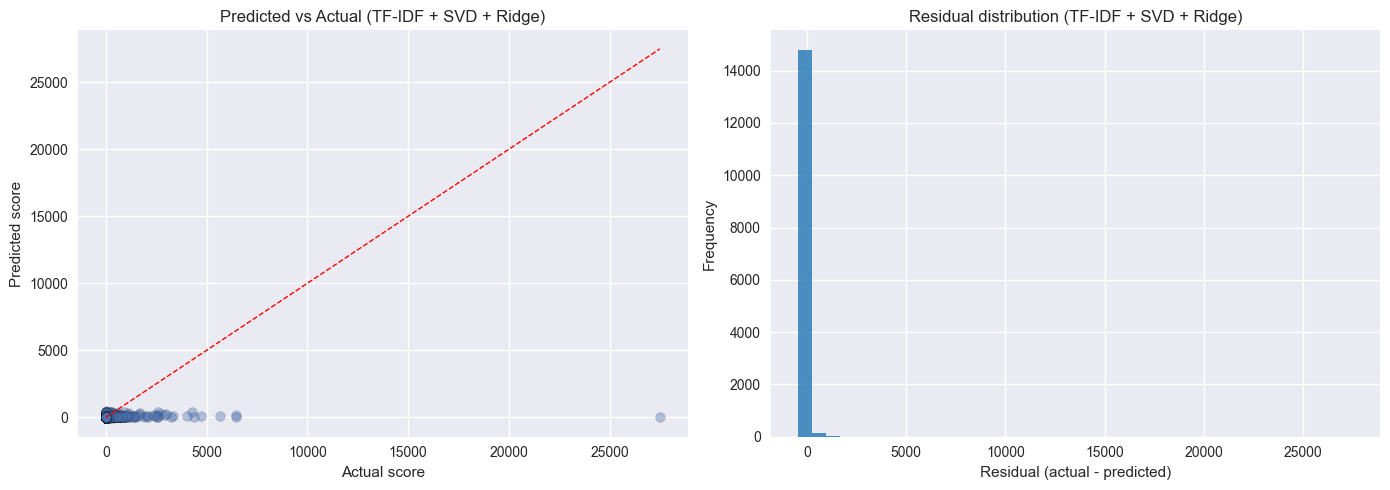

In [19]:
if best_test_predictions is None:
    raise RuntimeError('No final model available for plotting.')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].scatter(y_test, best_test_predictions, alpha=0.4, edgecolor='k', linewidth=0.2)
axes[0].set_xlabel('Actual score')
axes[0].set_ylabel('Predicted score')
axes[0].set_title(f'Predicted vs Actual ({best_model_name})')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=1)

residuals = y_test - best_test_predictions
axes[1].hist(residuals, bins=40, color='#1f77b4', alpha=0.8)
axes[1].set_xlabel('Residual (actual - predicted)')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Residual distribution ({best_model_name})')
plt.tight_layout()
plt.show()
